In [55]:
install.packages("showtext")
install.packages("sysfonts")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
install.packages(c("caret", "gbm", "xgboost", "randomForest", "Metrics", "ggplot2", "readr", "dplyr", "caretEnsemble"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘patchwork’, ‘pbapply’




In [29]:
# Load libraries
library(readr)
library(dplyr)
library(caret)
library(gbm)
library(xgboost)
library(randomForest)
library(Metrics)
library(ggplot2)
library(caretEnsemble)





In [57]:
library(showtext)
library(sysfonts)

# Tải Roboto
font_add_google("Roboto", "roboto")
showtext_auto()


In [30]:
# 1. Load data
df <- read_csv("students_habit_predict_mental_health.csv")
df <- df %>% select(-...1)

New names:
• `` -> `...1`
Rows: 1000 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): ...1, age, gender, study_hours_per_day, social_media_hours, netfli...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [32]:
# 2. Tách biến độc lập và biến mục tiêu
X <- df %>% select(-mental_health_rating)
y <- df$mental_health_rating

# 3. Chia dữ liệu Train/Test
set.seed(42)
train_index <- createDataPartition(y, p = 0.8, list = FALSE)
X_train <- X[train_index, ]
X_test <- X[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

In [33]:
# 4. Chuẩn hóa dữ liệu
preproc <- preProcess(X_train, method = c("center", "scale"))
X_train_scaled <- predict(preproc, X_train) %>% as.data.frame()
X_test_scaled <- predict(preproc, X_test) %>% as.data.frame()

In [34]:
# 5. Gradient Boosting (gbm) với hyperparameter tuning
set.seed(42)
gbm_grid <- expand.grid(
  n.trees = c(100, 300, 500),
  interaction.depth = c(3, 5, 7),
  shrinkage = c(0.01, 0.05, 0.1),
  n.minobsinnode = c(1, 3, 5)
)
gbm_model <- train(
  x = X_train_scaled,
  y = y_train,
  method = "gbm",
  tuneGrid = gbm_grid,
  trControl = trainControl(method = "cv", number = 5),
  verbose = FALSE
)

In [35]:
# 6. XGBoost cơ bản
xgb_train <- xgb.DMatrix(data = as.matrix(X_train_scaled), label = y_train)
xgb_test <- xgb.DMatrix(data = as.matrix(X_test_scaled), label = y_test)
xgb_model <- xgboost(
  data = xgb_train,
  objective = "reg:squarederror",
  nrounds = 100,
  verbose = 0
)

In [44]:
# 7. Stacking Regressor
set.seed(42)
stack_ctrl <- trainControl(
  method = "cv",
  number = 5,
  savePredictions = "final",
  verboseIter = FALSE,
  allowParallel = TRUE
)

models <- caretList(
  x = X_train_scaled,
  y = y_train,
  trControl = stack_ctrl,
  methodList = c("gbm", "rf", "xgbTree")
)

stack_model <- caretStack(models, method = "ridge")


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.8782            -nan     0.1000    0.1041
     2        7.7601            -nan     0.1000    0.0766
     3        7.6660            -nan     0.1000    0.0920
     4        7.5814            -nan     0.1000    0.0745
     5        7.5133            -nan     0.1000    0.0612
     6        7.4592            -nan     0.1000    0.0484
     7        7.4145            -nan     0.1000    0.0322
     8        7.3658            -nan     0.1000    0.0383
     9        7.3207            -nan     0.1000    0.0246
    10        7.2784            -nan     0.1000    0.0304
    20        6.9061            -nan     0.1000    0.0188
    40        6.3746            -nan     0.1000    0.0094
    60        5.9477            -nan     0.1000   -0.0150
    80        5.5621            -nan     0.1000   -0.0125
   100        5.2267            -nan     0.1000    0.0018
   120        4.9543            -nan     0.1000   -0.0075
   140        

In [49]:
# 8. Dự đoán
y_pred_gbm <- predict(gbm_model, X_test_scaled)
y_pred_xgb <- predict(xgb_model, newdata = as.matrix(X_test_scaled))
y_pred_stack <- predict(stack_model, newdata = X_test_scaled)
# Tránh lỗi: nếu là list thì unlist
if (is.list(y_pred_stack)) {
  y_pred_stack <- unlist(y_pred_stack)
}
# Đảm bảo kết quả là numeric vector
y_pred_stack <- as.numeric(y_pred_stack)

In [50]:
# 9. Đánh giá hiệu suất
R2_Score <- function(actual, predicted) {
  ss_res <- sum((actual - predicted)^2)
  ss_tot <- sum((actual - mean(actual))^2)
  1 - ss_res / ss_tot
}

results <- data.frame(
  Model = c("GBM", "XGBoost", "Stacking"),
  MSE = c(mse(y_test, y_pred_gbm), mse(y_test, y_pred_xgb), mse(y_test, y_pred_stack)),
  R2 = c(R2_Score(y_test, y_pred_gbm), R2_Score(y_test, y_pred_xgb), R2_Score(y_test, y_pred_stack))
)

results <- results %>% arrange(MSE)
print(results)

     Model      MSE        R2
1 Stacking 4.600073 0.4604309
2      GBM 4.850786 0.4310233
3  XGBoost 5.588860 0.3444503


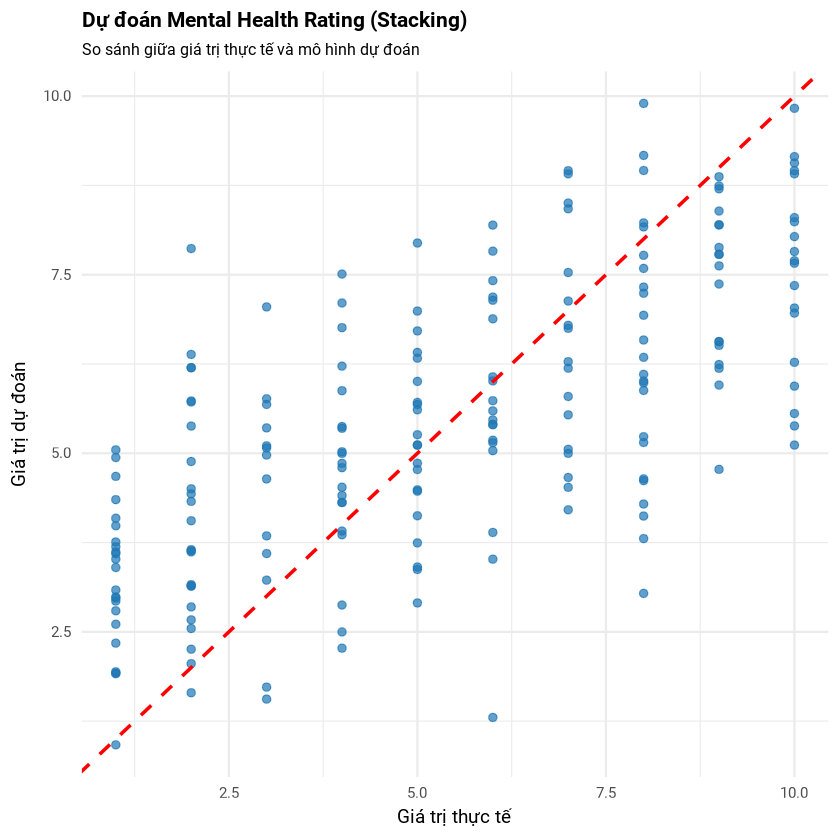

In [63]:
# 10. Biểu đồ dự đoán stacking vs thực tế
ggplot(data.frame(Actual = y_test, Predicted = y_pred_stack), aes(x = Actual, y = Predicted)) +
  geom_point(color = '#1f77b4', size = 2, alpha = 0.7) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red", linewidth = 1) +
  labs(
    title = "Dự đoán Mental Health Rating (Stacking)",
    subtitle = "So sánh giữa giá trị thực tế và mô hình dự đoán",
    x = "Giá trị thực tế",
    y = "Giá trị dự đoán"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    text = element_text(family = "roboto"),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(size = 12),
    axis.text = element_text(size = 11)
  )